![](https://i.pinimg.com/564x/6e/36/1b/6e361b8cf844a00e55253731e7b18fd6.jpg)

# OpenCV Camera

Kevin J. Walchko, Phd 

27 July 2017

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

----

Most useful robotics work requires calibrated camera in order to properly use the information distilled from each image. This will cover calibration of a single camera, but the basics apply to stereo calibration.


## References

- [OpenCV 4.2 Camera Calibration](https://docs.opencv.org/4.2.0/dc/dbb/tutorial_py_calibration.html)
- [OpenCV 2.4 Camera Calibration](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)
- [skimage ransac library](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.ransac)
- [Demystifying Geometric Camera Calibration for Intrinsic Matrix](https://kushalvyas.github.io/calib.html)

## Setup

In [1]:
# reload library
%load_ext autoreload
%autoreload 2

# plotting
%matplotlib inline 

In [2]:
import numpy as np
np.set_printoptions(precision=1)
np.set_printoptions(suppress=True)

import cv2
import time
# import pickle
# from pprint import pprint
from colorama import Fore
# import json
from glob import glob
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
from matplotlib.ticker import NullFormatter
import pylab                                 
pylab.rcParams['figure.figsize'] = (10.0, 18.0)

In [3]:
from opencv_camera import CameraCalibration
from opencv_camera import Markers
from opencv_camera import FlipBook
from opencv_camera import UnDistort
from opencv_camera import SaveVideo
import opencv_camera
import slurm

print(f">> opencv_camera version: {opencv_camera.__version__}")
print(f">> cv2 version: {cv2.__version__}")
print(f">> slurm version: {slurm.__version__}")

>> opencv_camera version: 0.10.3
>> cv2 version: 4.2.0
>> slurm version: 0.4.3


In [4]:
def get_images(path, gray=False):
    """
    Given a path, it reads all images. This uses glob to grab file names
    and excepts wild cards *
    Ex. getImages('./images/*.jpg')
    """
    imgs = []
    files = glob(path)
    files.sort()

    print("Found {} images at {}".format(len(tuple(files)), path))
    # print('-'*40)

    for i, f in enumerate(files):
        img = cv2.imread(f)
        if img is None:
            print(f'{Fore.RED}>> Could not read: {f}{Fore.RESET}')
        else:
            if gray and len(img.shape) > 2:
               img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            r,c = img.shape
            print(f"{Fore.GREEN}[{i}]:{Fore.RESET}{f} ({r}x{c})")
            imgs.append(img)
    # print('-'*40)
    return imgs

# Camera Model

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

![Pinhole Camera Model](images/pinhole_camera_model.png)

\begin{eqnarray}
  s p' = A[R|t]P' \\
  s \begin{bmatrix} u\\ v\\ 1 \end{bmatrix} = 
  \begin{bmatrix}
    f_x & a & c_x \\
    0 & f_y & c_y \\
    0 & 0 & 1
  \end{bmatrix}
  \begin{bmatrix} R_{3x3} & t_{xyz} \end{bmatrix}
  \begin{bmatrix} X \\ Y \\ Z \\ 1 \end{bmatrix}
\end{eqnarray}

where:

- P(X, Y, Z) are the coordinates of a 3D point in the world coordinate space
- p(u, v) are the coordinates of the projection point in pixels
- A is a camera matrix, or a matrix of **intrinsic** parameters (think internal parameters)
- (cx, cy) is a principal point that is usually at the image center
- fx, fy are the focal lengths expressed in pixel units
- [R|t] are the **extrinsic** parameters (think external parameters)
- a is a skewing parameter that transforms square pixels into parallograms. Note, this is only a simple skewing in 1 parameter, it can effect all off diagional terms in the top, left 3x3.

The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when $z \ne 0$ ):

\begin{eqnarray}
  \begin{bmatrix} x \\ y \\ z \end{bmatrix}^{camera} = R_{3x3}
  \begin{bmatrix} X \\ Y \\ Z \end{bmatrix}^{world} + t_{xyz} \\
  x' = \frac{x}{z} \\
  y' = \frac{y}{z} \\
  u = f_x*x'+c_x \\
  v = f_y*y'+c_y
\end{eqnarray}

where (X,Y,Z) are world space coordinates with units of meters, (x,y,z) are rotated/translated to the camera's coordinate system with units of meters, (x',y') are normalized (divided by z, these are unitless) in the camera's FOV, and (u,v) are finally projected onto the camera's image plane with units of pixels. 

## Focal Length

![](images/focal-length.jpg)

The focal length of a camera is an important aspect for a couple of reasons.

1. A properly designed camera has a focal length which ensures your entire image plane is illuminated with light
1. Your focal length also determines your field of view.

$$
\alpha = 2 \cdot arctan2(w, 2f) \\
f = \frac{w}{2} \cot( \frac{\alpha}{2} )
$$

A lot of cameras have a fixed focal length, like our cell phone camera used with the raspberry pi, but some cameras have a mechanical zoom feature which narrows the FOV and allow more pixels across a smaller area.

All cameras have a digital zoom, where they smartly average pixels together to simulate a mechanical zoom, but it really isn't a zoom. You are better off taking the native image and then "zooming" and cropping the image in software later.

## Distortions

If everything was perfect, the red lines in the image below would lie neatly on the checkerboard.

![](images/distortion.jpg)

However, there are always little distortions in the lense (or misalignments) that break this model. Typically you must correct for radial ($k_{1-6}$) and tangential ($p_{1-2}$) distortions coefficients which effect the $x'$ and $y'$ terms in a nonlinear manor. The pictures below show the barrel distortion (typically $k_1 > 0$) and pincushion distortion (typically $k_1 < 0$).

![](images/distortion_examples.png)

## Calibration

![](images/cal-images.jpg)

So how do we do this? The calibration code for the checkerboard does:

1. Converts image to grayscale
1. Searches for the intersections of the chessboard and should find 9x6 of them (i.e., 54 intersections)
1. Using homography and knowing that we are using a chessboard, it then uses an algorithm, typically RANSAC, to figure out the how the calibration target was warped in order to match the image.
    1. Note, there are other camera targets besides the classic chessboard: circular grids, apriltags, AruCo tags, ChAruCo tags, etc.
    1. Chessboard and any other pattern that has corner intersections, perform better than trying to estimate the center of a circle
1. It then returns your calculated camera matrix and distortion parameters (the k's mentioned above) which allow you to remove distortion from an image

## Calibration Patterns

OpenCV supports several patterns:

<span>
  <img src="patterns/checkerboard.jpg" width="30%"> 
  <img src="patterns/symetric-circles.jpg" width="30%"> 
  <img src="patterns/asymetric-circles.jpg" width="30%">  
</span>

Generally, the checkerboard pattern performs the best. Mainly because the algorithms are simple and effective to finding the intersections of the black/white squares. The circles use a more complex algorithm and have to determine the center of mass correctly. Unfortunately, camera lens distortion can cause the centers to be off just a little and the calibration not as good as the checkerboard.

<img src="patterns/intersection.png" width="30%">

## Performance

How do you know you did a good job? The function `cv2.calibrateCamera()` returns an RMS value in pixels, so:

- **BAD:** RMS > 1.0px
- **OK:** RMS < 1.0px
- **GOOD:** RMS < 0.5px

However, RMS is necessary but not sufficient for good calibration. Low RMS means the algorithm was able to minimize the objective function on the given inputs **on average**. You need to look at the global results (i.e., image per image, corner per corner) to see how it performs. Thus, you will typically see people reproject the points using the new calibration matrix and then calculating the error from that.

In [5]:
def errorhistogram(x, y):
    """
    This plots the x and y errors from reprojection. The x and y errors
    should be in units of pixels.
    """
    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(6, 6))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHistx.set_title('Reprojection Error [pixels]')
    axHisty = plt.axes(rect_histy)

    # no labels
    axHistx.xaxis.set_major_formatter(nullfmt)
    axHisty.yaxis.set_major_formatter(nullfmt)

    # the scatter plot:
    axScatter.scatter(x, y)

    # now determine nice limits by hand:
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    binwidth = 2*xymax/20  # 0.025
    lim = (int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim((-lim, lim))
    axScatter.set_ylim((-lim, lim))
    axScatter.grid(True)
    axScatter.set_xlabel('x [pixel]')
    axScatter.set_ylabel('y [pixel]')

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')
    axHistx.grid(True)
    axHisty.grid(True)

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

# OpenCV Calibration

So let's load a bunch of images with chessboards on them. The full set comes from OpenCV and is shown below:

![](images/opencv-cal.png)

Found 13 images at cal_images/left*.jpg
[0]:cal_images/left01.jpg (480x640)
[1]:cal_images/left02.jpg (480x640)
[2]:cal_images/left03.jpg (480x640)
[3]:cal_images/left04.jpg (480x640)
[4]:cal_images/left05.jpg (480x640)
[5]:cal_images/left06.jpg (480x640)
[6]:cal_images/left07.jpg (480x640)
[7]:cal_images/left08.jpg (480x640)
[8]:cal_images/left09.jpg (480x640)
[9]:cal_images/left11.jpg (480x640)
[10]:cal_images/left12.jpg (480x640)
[11]:cal_images/left13.jpg (480x640)
[12]:cal_images/left14.jpg (480x640)


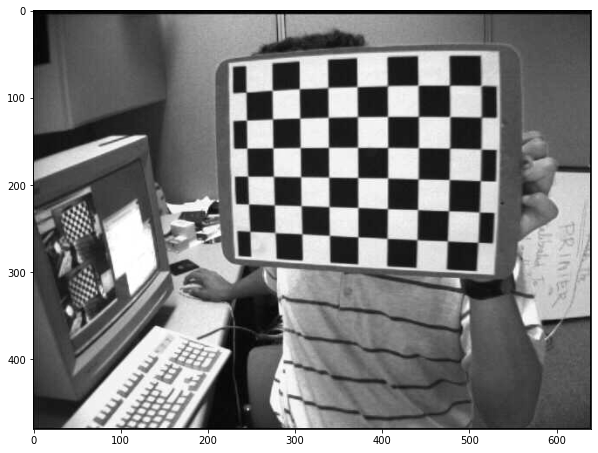

In [6]:
path = 'cal_images/left*.jpg'
images = get_images(path, gray=True)
plt.imshow(images[0], cmap='gray');

In [7]:
# create a calibration instance called cal
cal = CameraCalibration(Markers.checkerboard, marker_size=(9, 6))

# calibrate using the images and the 9x6 checkerboard
# Note: 9x6 refers to the intersections, not the boxes
data = cal.calibrate(images)

Images: 13 @ (480, 640)
Markers.checkerboard (9, 6)
----------------------------------------
[0] + found 54.0 of 54 corners
[1] + found 54.0 of 54 corners
[2] + found 54.0 of 54 corners
[3] + found 54.0 of 54 corners
[4] + found 54.0 of 54 corners
[5] + found 54.0 of 54 corners
[6] + found 54.0 of 54 corners
[7] + found 54.0 of 54 corners
[8] + found 54.0 of 54 corners
[9] + found 54.0 of 54 corners
[10] + found 54.0 of 54 corners
[11] + found 54.0 of 54 corners
[12] + found 54.0 of 54 corners
RMS error: 0.19543358784937945
----------------------------------------


The resulting camera info shows a low level of distortion, so the effect with and without the correction will be small to the human eye. However, for computer vision work, it could make a difference.

If we print out the camera matrix:

In [8]:
for k,v in data.items():
    print(f"{k}: {v}")

date: Fri, 03 Jul 2020 12:27:37
markerType: Markers.checkerboard
markerSize: (9, 6)
imageSize: (480, 640)
cameraMatrix: [[532.8   0.  342.5]
 [  0.  532.9 233.9]
 [  0.    0.    1. ]]
distCoeffs: DistortionCoefficients(k1=-0.28088090992383424, k2=0.025171656272961, p1=0.0012165734621724154, p2=-0.00013554940417942078, k3=0.16344891215736113)
rms: 0.19543358784937945
rvecs: [array([[0.2],
       [0.3],
       [0. ]]), array([[ 0.4],
       [ 0.7],
       [-1.3]]), array([[-0.3],
       [ 0.2],
       [ 0.4]]), array([[-0.1],
       [ 0.2],
       [-0. ]]), array([[-0.3],
       [ 0.4],
       [ 1.3]]), array([[0.4],
       [0.3],
       [1.6]]), array([[0.2],
       [0.3],
       [1.9]]), array([[-0.1],
       [ 0.5],
       [ 1.8]]), array([[ 0.2],
       [-0.4],
       [ 0.1]]), array([[-0.4],
       [-0.5],
       [ 1.3]]), array([[-0.2],
       [ 0.3],
       [ 1.5]]), array([[ 0.5],
       [-0.3],
       [ 1.2]]), array([[-0.2],
       [-0.5],
       [ 1.3]])]
tvecs: [array([[-3. ]

In [9]:
M = data["cameraMatrix"]

print('Camera Matrix:\n', M,"\n")
print(f'Focal Length (fx,fy) = ({M[0][0]:.0f}, {M[1][1]:.0f})')
print(f'Principle Point (cx,cy) = ({M[0][2]:.0f}, {M[1][2]:.0f})')
print(data["distCoeffs"])

Camera Matrix:
 [[532.8   0.  342.5]
 [  0.  532.9 233.9]
 [  0.    0.    1. ]] 

Focal Length (fx,fy) = (533, 533)
Principle Point (cx,cy) = (342, 234)
DistortionCoefficients(k1=-0.28088090992383424, k2=0.025171656272961, p1=0.0012165734621724154, p2=-0.00013554940417942078, k3=0.16344891215736113)


## Undistort Image

Now let's read back in an image and use the calibration matrix to undistort it.

In [10]:
d = data["distCoeffs"]

un = UnDistort(d,M)

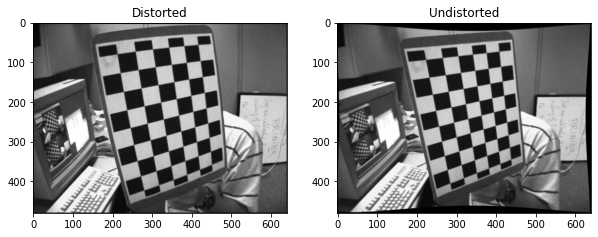

In [11]:
# read in a grayscale image
image = images[12]

# 0 = no black pixels
# 0<alpha<1 = some percent of black pixels
# 1 = keep all pixels including black
better = un.undistort(image,1)

plt.subplot(1,2,1)
plt.imshow(image, cmap='gray');
plt.title('Distorted')

plt.subplot(1,2,2)
plt.imshow(better, cmap='gray');
plt.title('Undistorted');

Hopefully you can see the warping in the middle of the image is gone in the right side. Cameras are made much better now, than they use to be, so for a lot of single camera applications this is not necessary. However, for stereo vision (2 or more cameras) or some of the 3D work, it is necessary to calibrate your cameras.